The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp



import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL
from functions import *

Now using different method to find best xgboost version

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in six pieces. 

In [2]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
real_power6=pd.read_csv(path+"Realisierter_Stromverbrauch_202401030000_202403112359_Viertelstunde.csv",delimiter=';')

Processing them. 

In [3]:
print(real_power5.columns)

Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')


In [4]:
processed1=prepare_input(real_power1,old=True,str_convert=False)
processed2=prepare_input(real_power2,old=True,str_convert=False)
processed3=prepare_input(real_power3,old=True,str_convert=False)
processed4=prepare_input(real_power4,old=True,str_convert=False)
processed5=prepare_input(real_power5,old=False,str_convert=True)
processed6=prepare_input(real_power6,old=False,str_convert=True)

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:561: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/

Combine them and plot for checking. 

dimensions of the data are (355488, 5)


Text(0, 0.5, 'total power [GW]')

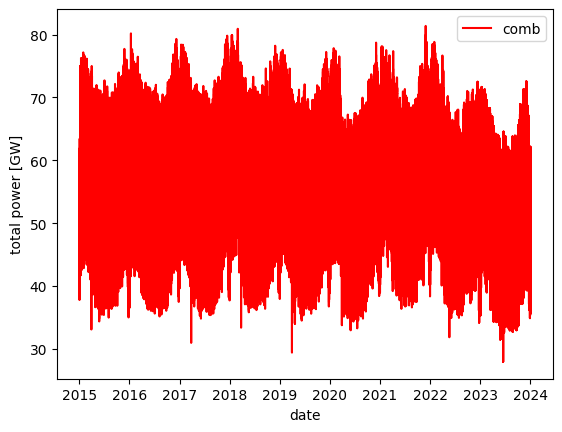

In [5]:
#date_time is set to index
processed1=processed1.set_index('date_time')
processed2=processed2.set_index('date_time')
processed3=processed3.set_index('date_time')
processed4=processed4.set_index('date_time')
processed5=processed5.set_index('date_time')
processed6=processed6.set_index('date_time')

#combining with concat
comb_real_power=pd.concat([processed4,processed3,processed2,processed1,processed5,processed5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Including new worked. 

In [6]:
#freeing space 
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0
real_power6=0
processed1=0
processed2=0
processed3=0
processed4=0
processed5=0
processed6=0

No official predictions for now. 

In [7]:
#pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
#pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
#pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
#pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
#pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

No gap prediction for now. 

In [8]:
#first now then to predict, here the 96 will be varies to get for many periods 
ser=series_to_supervised(comb_real_power.total_power,1,96)
print(ser.shape,ser[0:10,0:10])

(355391, 2) [[11.21  11.306]
 [11.119 11.019]
 [11.145 10.877]
 [11.127 10.818]
 [11.01  10.687]
 [10.923 10.616]
 [10.817 10.55 ]
 [10.705 10.5  ]
 [10.65  10.451]
 [10.547 10.405]]


Make to data frame

In [9]:
df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
df_ser.loc[:,'frac_day']=comb_real_power.loc[0:df_ser.shape[0],'frac_day']
df_ser.loc[:,'frac_week']=comb_real_power.loc[0:df_ser.shape[0],'frac_week']
df_ser.loc[:,'frac_year']=comb_real_power.loc[0:df_ser.shape[0],'frac_year']

In [10]:
print(df_ser.columns)
frac1=int(df_ser.shape[0]*0.8)
print(frac1)
ser_train=df_ser.iloc[:frac1,:]
ser_test=df_ser.iloc[frac1:,:]
x_train=ser_train.loc[:,['now','frac_day', 'frac_week']]
y_train=ser_train.loc[:,'to_predict']
x_test=ser_test.loc[:,['now','frac_day', 'frac_week']]
y_test=ser_test.loc[:,'to_predict']

Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284312


In [11]:
model = XGBRegressor()
eval_set = [(x_test, y_test)]

In [12]:
model.fit(x_train, y_train, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:8.84783


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:6.14726
[2]	validation_0-rmse:4.27156
[3]	validation_0-rmse:2.97814
[4]	validation_0-rmse:2.09120
[5]	validation_0-rmse:1.49641
[6]	validation_0-rmse:1.10197
[7]	validation_0-rmse:0.86688
[8]	validation_0-rmse:0.75059
[9]	validation_0-rmse:0.69455
[10]	validation_0-rmse:0.67583
[11]	validation_0-rmse:0.67314
[12]	validation_0-rmse:0.67548
[13]	validation_0-rmse:0.67800
[14]	validation_0-rmse:0.68224


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
y_pred = model.predict(x_test)

In [14]:
#uses best automatically, maybe always, but jsut fatsre wouldf be enough of adventage 
print(((y_test-y_pred)/np.mean(y_pred)).describe())

count    71079.000000
mean        -0.002477
std          0.051516
min         -0.390916
25%         -0.025945
50%          0.000907
75%          0.025662
max          0.245938
Name: to_predict, dtype: float64


5.15% standard deviation, same as before (slightky different test sample), but should be faster. 

In [15]:
print(model.evals_result())
results = model.evals_result()
s=np.argmin(results['validation_0']['rmse'])
print(results['validation_0']['rmse'][s])

{'validation_0': OrderedDict([('rmse', [8.847827382548546, 6.147258290231909, 4.2715608731869175, 2.978144023720723, 2.09119826494975, 1.4964136543156505, 1.1019666035645876, 0.8668757142475173, 0.7505882823608969, 0.6945474752296621, 0.6758343725292242, 0.6731356594667031, 0.675480350334407, 0.6779966506491001, 0.6822386853970432])])}
0.6731356594667031


In [16]:
x_train2=ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_train2=ser_train.loc[:,'to_predict']
x_test2=ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_test2=ser_test.loc[:,'to_predict']
model2 = XGBRegressor()
eval_set2 = [(x_test2, y_test2)]

In [17]:
model2.fit(x_train2, y_train2, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set2, verbose=True)

[0]	validation_0-rmse:8.84521


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:6.13913
[2]	validation_0-rmse:4.25771
[3]	validation_0-rmse:2.94930
[4]	validation_0-rmse:2.02929
[5]	validation_0-rmse:1.43781
[6]	validation_0-rmse:1.03421
[7]	validation_0-rmse:0.79341
[8]	validation_0-rmse:0.67062
[9]	validation_0-rmse:0.61581
[10]	validation_0-rmse:0.60195
[11]	validation_0-rmse:0.59536
[12]	validation_0-rmse:0.60120
[13]	validation_0-rmse:0.60564


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [18]:

y_pred2 = model2.predict(x_test2)
print(((y_test2-y_pred2)/np.mean(y_pred2)).describe())

count    71079.000000
mean        -0.008739
std          0.044480
min         -0.405448
25%         -0.030084
50%         -0.005224
75%          0.016811
max          0.224894
Name: to_predict, dtype: float64


In [19]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
#now best n_est, is given back, that not more are run
def do_xgb_nest(feature_train, target_train, feature_test, target_test,max_depth,reg=0,silent=False,rounds=3):
    start_time=datetime.now()
    #no regularization option
    if reg==0:
        model = XGBRegressor(max_depth=max_depth)
    else:
        model = XGBRegressor(max_depth=max_depth,reg_alpha=reg)   
    eval_set = [(feature_test, target_test)]
    model.fit(feature_train, target_train, early_stopping_rounds=rounds, eval_metric="rmse", eval_set=eval_set, verbose=silent)
    results = model.evals_result()
    s=np.argmin(results['validation_0']['rmse'])
    predli1texl27=model.predict(feature_test)
    predli1trxl27=model.predict(feature_train)
    test_scatter=np.std(predli1texl27-target_test)
    train_scatter=np.std(predli1trxl27-target_train)
    test_m=np.mean(predli1texl27-target_test)
    train_m=np.mean(predli1trxl27-target_train)
    test_rsme=np.sqrt((test_m**2+test_scatter**2))
    train_rsme=np.sqrt((train_m**2+train_scatter**2))   
    if silent==False:
        print(f"best n_estimator is {s+1}")
        print(f"rsme of test {round(test_rsme,4)} points")
        print(f"rsme of train {round(train_rsme,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((5))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_rsme
    ar[3]=test_rsme
    ar[4]=s+1   
    stop_time=datetime.now()
    if silent==False:
        print(f"xgb took {(stop_time-start_time)} seconds")
    return ar

In [20]:
test_res=do_xgb_nest(x_train,y_train,x_test,y_test,max_depth=4,rounds=10)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:03.255101 seconds


In [21]:
test_res2=do_xgb(x_train,y_train,x_test,y_test,max_depth=4)

standard deviation of test 2.2568 points
standard deviation of train 2.4945  points
standard deviation of prediction-test 0.6763 points
standard deviation of prediction-train 0.6073 points
xgb took 0:00:05.481246 seconds


Yes is faster now, when round number is small. Also rsme used which helps to reduce the bias. 

In [76]:
def loop_reg_nest(feature_train, target_train, feature_test, target_test,max_depth=6,reg_start=0.01,reg_increase=1.414,reg_steps=20,save=False,file_name=None,regression=True,silent=False,rounds=3,limit=1.05):
    #that takes now some time
    resb=np.zeros((5,reg_steps))
    for i in range(reg_steps):
        if silent==False:
            print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        #regression
        if regression==True:
            print(rounds)
            ar=do_xgb_nest(feature_train,target_train,feature_test,target_test,max_depth=max_depth,rounds=rounds,reg=regularization,silent=silent)  
                
        #classification not yet implemented
        else:
            ar=do_xgb_class(feature_train, target_train, feature_test, target_test,max_depth=max_depth,reg=regularization,silent=silent)
        resb[:,i]=ar           
        #early stopping
        if ar[2]>ar[3]*limit:
             return resb[:,:i]
    #saved now only at the end seems stable enough now
    if save==True:
        np.savetxt(file_name, resb) 
    else:
        return resb

In [23]:
test_loop=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,save=False,regression=True,silent=False,rounds=25,limit=1.02)

doing case 0
25


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:04.621673 seconds
doing case 1
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:05.177058 seconds
doing case 2
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:03.999786 seconds
doing case 3
25
best n_estimator is 45
rsme of test 0.6796 points
rsme of train 0.6242 points
xgb took 0:00:03.754552 seconds
doing case 4
25
best n_estimator is 41
rsme of test 0.6839 points
rsme of train 0.6277 points
xgb took 0:00:03.553725 seconds
doing case 5
25
best n_estimator is 41
rsme of test 0.6839 points
rsme of train 0.6277 points
xgb took 0:00:03.588547 seconds
doing case 6
25
best n_estimator is 44
rsme of test 0.6812 points
rsme of train 0.6261 points
xgb took 0:00:03.741491 seconds
doing case 7
25
best n_estimator is 39
rsme of test 0.6904 points
rsme of train 0.6295 points
xgb took 0:00:03.412253 seconds
doing ca

Text(0.5, 1.0, '4 features')

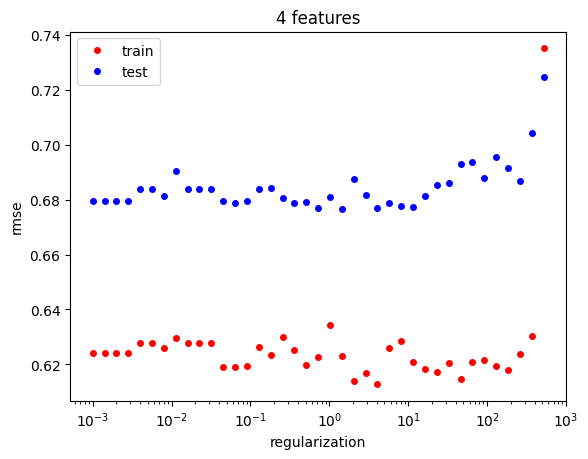

In [27]:

plt.plot(test_loop[0],test_loop[2],'o',ms=4,color='red',label="train")  
plt.plot(test_loop[0],test_loop[3],'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

More scatter than before, 10 and 12, 15 rounds not enough. I am not convinvced that this method really makes it better. Now seems to work with 25, somewhat doubtful, that this still really better, speed wise. 

Text(0.5, 1.0, '4 features')

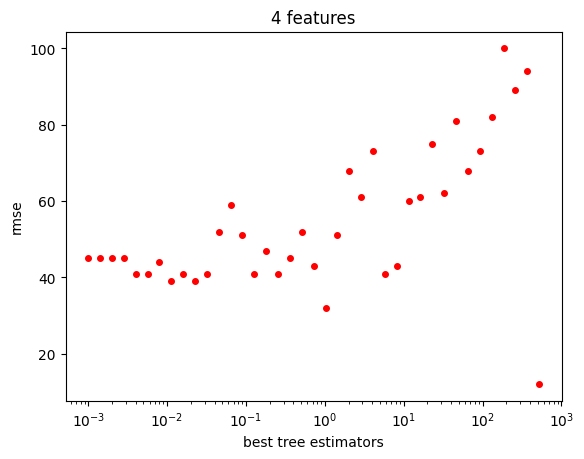

In [28]:

plt.plot(test_loop[0],test_loop[4],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("best tree estimators")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

Fraction of day is not important, probably its prediction properrties are similar as current state. 

In [26]:
#plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']].columns, xmodel2.feature_importances_)
#plt.xticks(rotation = 90)
#plt.show()

NameError: name 'xmodel2' is not defined

In [77]:
def find_best2(dat,delta=3):
    min_p=np.argmin(dat[3])
    est=np.zeros((3))
    print(dat[0,min_p])
    print(dat[0:4,min_p-delta:min_p+delta])
    if min_p-delta>=0:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,min_p-delta:min_p+delta],dat[3,min_p-delta:min_p+delta],p0=est)
    else:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,0:min_p+delta],dat[3,0:min_p+delta],p0=est)
    print(val)
    min_p1=10**dev_quat(val[0],val[1],val[2])
    print(min_p1)
    print(dat)
    s=np.argmin(np.abs(min_p1-dat[3]))
    print(s,dat[4,s])
    return min_p1, dat[4,s], s
    

In [66]:
#xmodel3=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
#xmodel3.save_model("xgb_model_096.json")


In [67]:
#xmodel4=XGBRegressor()
#xmodel4.load_model("xgb_model_096.json")

Basic works, now making all to a function that it can be produced for a number of time deltas. 
First for single time delta. 

Should give out standard deviation of test at some point also. 

In [78]:
#parameters data frame, gap to wanted prediction
def find_fit_best_reg2(df,gap,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25):
    print(gap)
    ser=series_to_supervised(df.total_power,now_points,gap)
    df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
    df_ser.loc[:,'frac_day']=df.loc[0:df_ser.shape[0],'frac_day']
    df_ser.loc[:,'frac_week']=df.loc[0:df_ser.shape[0],'frac_week']
    df_ser.loc[:,'frac_year']=df.loc[0:df_ser.shape[0],'frac_year']
    print(df_ser.shape)
    print(df_ser.columns)
    frac1=int(df_ser.shape[0]*0.8)
    print(frac1)
    ser_train=df_ser.iloc[:frac1,:]
    ser_test=df_ser.iloc[frac1:,:]
    print(reg_steps)
    stat_reg=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,save=False,regression=True,silent=False,rounds=rounds)
    print(stat_reg)
    best_reg, best_nest,s=find_best2(stat_reg,delta=delta)
    print(best_nest)
    xmodel=XGBRegressor(alpha=best_reg,max_depth=max_depth,n_estimators=int(best_nest)).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
    test_rsme=stat_reg[3,s]
    print(test_rsme)
    if save==True:
        xmodel.save_model(filename)
        return test_rsme
    else:
        return xmodel, test_rsme

In [79]:
test_rsme=find_fit_best_reg2(comb_real_power,1,reg_steps=4,rounds=25,filename="xgb2_model_001.json")

1
[[11.21    11.145  ]
 [11.119   11.127  ]
 [11.145   11.01   ]
 ...
 [12.50175 12.0955 ]
 [12.2905  11.8315 ]
 [12.0955  11.72175]]
(355486, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284388
4
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    11.14500  0.000000   0.000000   0.000000
1       11.11900    11.12700  0.010417   0.001488   0.000029
2       11.14500    11.01000  0.020833   0.002976   0.000057
3       11.12700    10.92300  0.031250   0.004464   0.000086
4       11.01000    10.81700  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284383  16.76475    17.17400  0.322917   0.188988   0.110398
284384  17.07075    17.25125  0.333333   0.190476   0.110427
284385  17.17400    17.28650  0.343750   0.191964   0.110455
284386  17.25125    17.24975  0.354167   0.193452   0.110484
284387  17.28650    17.31000  0.364583   0.194940   0.110512

[284388 rows x 5 columns]
   

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 100
rsme of test 0.1392 points
rsme of train 0.1204 points
xgb took 0:00:04.156750 seconds
doing case 1
25
best n_estimator is 100
rsme of test 0.1391 points
rsme of train 0.1221 points
xgb took 0:00:03.353417 seconds
doing case 2
25
best n_estimator is 100
rsme of test 0.1391 points
rsme of train 0.1208 points
xgb took 0:00:03.346351 seconds
doing case 3
25
best n_estimator is 100
rsme of test 0.1381 points
rsme of train 0.1211 points
xgb took 0:00:03.310588 seconds
[[1.00000000e-03 1.41400000e-03 1.99939600e-03 2.82714594e-03]
 [4.00000000e+00 4.00000000e+00 4.00000000e+00 4.00000000e+00]
 [1.20401246e-01 1.22108721e-01 1.20812288e-01 1.21057599e-01]
 [1.39248740e-01 1.39075833e-01 1.39112747e-01 1.38099931e-01]
 [1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]]
0.002827145944
[[2.82714594e-03]
 [4.00000000e+00]
 [1.21057599e-01]
 [1.38099931e-01]]
[ 0.06145828 -0.0537391  -0.00927665]
0.0012691931475395035
[[1.00000000e-03 1.41400000e-03 1.99939600e-

In [83]:
print(test_rsme)
print(np.mean(y_test))

0.13809993141562413
13.01912874759071


Seems to work. 

Make function to many of them. but is only run when also better feature for year are ready, not enough progress otherwise.

In [84]:
def fit_many_gaps2(df,base_name='xgb2_model',gap_start=1,gap_steps=2,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25):
    results=np.zeros((2,gap_steps))
    for i in range(gap_steps):
        gap=gap_start+i
        print(gap)
        if gap<10:
            filename=base_name+"_00"+str(gap)+".json"
        elif gap<100:
            filename=base_name+"_0"+str(gap)+".json"
        elif gap<1000:
            filename=base_name+"_"+str(gap)+".json"            
        rsme=find_fit_best_reg2(df,gap,now_points=now_points,test_frac=test_frac,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,delta=delta,filename=filename,save=True,rounds=rounds)
        results[0,i]=gap
        results[1,i]=rsme
    return results    

In [94]:
#101 seems bad 
rsme_results=fit_many_gaps2(comb_real_power,base_name='xgb2_model',reg_steps=40,reg_start=0.0010,gap_start=96,gap_steps=4,rounds=25)

96
96
[[11.21    11.306  ]
 [11.119   11.019  ]
 [11.145   10.877  ]
 ...
 [10.42    12.0955 ]
 [10.2275  11.8315 ]
 [10.085   11.72175]]
(355391, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284312
40
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    11.30600  0.000000   0.000000   0.000000
1       11.11900    11.01900  0.010417   0.001488   0.000029
2       11.14500    10.87700  0.020833   0.002976   0.000057
3       11.12700    10.81800  0.031250   0.004464   0.000086
4       11.01000    10.68700  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284307  17.26125    16.75775  0.531250   0.075893   0.108231
284308  17.24400    16.61075  0.541667   0.077381   0.108259
284309  17.08650    16.57800  0.552083   0.078869   0.108288
284310  16.86475    16.42250  0.562500   0.080357   0.108316
284311  16.66575    16.27600  0.572917   0.081845   0.108345

[284312 rows x 5 columns

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 90
rsme of test 0.6238 points
rsme of train 0.4959 points
xgb took 0:00:03.708410 seconds
doing case 1
25
best n_estimator is 90
rsme of test 0.6238 points
rsme of train 0.4959 points
xgb took 0:00:03.426317 seconds
doing case 2
25
best n_estimator is 90
rsme of test 0.6238 points
rsme of train 0.4959 points
xgb took 0:00:03.422001 seconds
doing case 3
25
best n_estimator is 90
rsme of test 0.6238 points
rsme of train 0.4959 points
xgb took 0:00:03.638291 seconds
doing case 4
25
best n_estimator is 62
rsme of test 0.6157 points
rsme of train 0.508 points
xgb took 0:00:03.231080 seconds
doing case 5
25
best n_estimator is 62
rsme of test 0.6157 points
rsme of train 0.508 points
xgb took 0:00:03.653770 seconds
doing case 6
25
best n_estimator is 97
rsme of test 0.624 points
rsme of train 0.4775 points
xgb took 0:00:03.548261 seconds
doing case 7
25
best n_estimator is 95
rsme of test 0.6091 points
rsme of train 0.486 points
xgb took 0:00:04.069436 seconds
doing case 8

0.6053314054300535
97
97
[[11.21    11.019  ]
 [11.119   10.877  ]
 [11.145   10.818  ]
 ...
 [10.557   12.0955 ]
 [10.42    11.8315 ]
 [10.2275  11.72175]]
(355390, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284312
40
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    11.01900  0.000000   0.000000   0.000000
1       11.11900    10.87700  0.010417   0.001488   0.000029
2       11.14500    10.81800  0.020833   0.002976   0.000057
3       11.12700    10.68700  0.031250   0.004464   0.000086
4       11.01000    10.61600  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284307  17.26125    16.61075  0.531250   0.075893   0.108231
284308  17.24400    16.57800  0.541667   0.077381   0.108259
284309  17.08650    16.42250  0.552083   0.078869   0.108288
284310  16.86475    16.27600  0.562500   0.080357   0.108316
284311  16.66575    16.19125  0.572917   0.081845   0.108345

[2843

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 96
rsme of test 0.6335 points
rsme of train 0.4931 points
xgb took 0:00:05.889684 seconds
doing case 1
25
best n_estimator is 100
rsme of test 0.6334 points
rsme of train 0.4911 points
xgb took 0:00:05.739062 seconds
doing case 2
25
best n_estimator is 100
rsme of test 0.6334 points
rsme of train 0.4911 points
xgb took 0:00:05.200075 seconds
doing case 3
25
best n_estimator is 96
rsme of test 0.6343 points
rsme of train 0.4935 points
xgb took 0:00:05.644724 seconds
doing case 4
25
best n_estimator is 100
rsme of test 0.6334 points
rsme of train 0.4911 points
xgb took 0:00:05.220570 seconds
doing case 5
25
best n_estimator is 96
rsme of test 0.6335 points
rsme of train 0.4931 points
xgb took 0:00:05.155859 seconds
doing case 6
25
best n_estimator is 87
rsme of test 0.633 points
rsme of train 0.4948 points
xgb took 0:00:05.029493 seconds
doing case 7
25
best n_estimator is 96
rsme of test 0.6335 points
rsme of train 0.4931 points
xgb took 0:00:05.502366 seconds
doing 

0.6319988771399161
98
98
[[11.21    10.877  ]
 [11.119   10.818  ]
 [11.145   10.687  ]
 ...
 [10.7365  12.0955 ]
 [10.557   11.8315 ]
 [10.42    11.72175]]
(355389, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284311
40
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    10.87700  0.000000   0.000000   0.000000
1       11.11900    10.81800  0.010417   0.001488   0.000029
2       11.14500    10.68700  0.020833   0.002976   0.000057
3       11.12700    10.61600  0.031250   0.004464   0.000086
4       11.01000    10.55000  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284306  17.27150    16.61075  0.520833   0.074405   0.108202
284307  17.26125    16.57800  0.531250   0.075893   0.108231
284308  17.24400    16.42250  0.541667   0.077381   0.108259
284309  17.08650    16.27600  0.552083   0.078869   0.108288
284310  16.86475    16.19125  0.562500   0.080357   0.108316

[2843

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 77
rsme of test 0.6802 points
rsme of train 0.5277 points
xgb took 0:00:05.561887 seconds
doing case 1
25
best n_estimator is 77
rsme of test 0.6802 points
rsme of train 0.5277 points
xgb took 0:00:05.875390 seconds
doing case 2
25
best n_estimator is 91
rsme of test 0.6766 points
rsme of train 0.5161 points
xgb took 0:00:05.803195 seconds
doing case 3
25
best n_estimator is 91
rsme of test 0.6766 points
rsme of train 0.5161 points
xgb took 0:00:07.829125 seconds
doing case 4
25
best n_estimator is 91
rsme of test 0.6766 points
rsme of train 0.5161 points
xgb took 0:00:07.798382 seconds
doing case 5
25
best n_estimator is 95
rsme of test 0.6813 points
rsme of train 0.5129 points
xgb took 0:00:05.946193 seconds
doing case 6
25
best n_estimator is 91
rsme of test 0.6766 points
rsme of train 0.5161 points
xgb took 0:00:05.638743 seconds
doing case 7
25
best n_estimator is 77
rsme of test 0.6802 points
rsme of train 0.5277 points
xgb took 0:00:05.072485 seconds
doing ca

0.6699581241380046
99
99
[[11.21    10.818  ]
 [11.119   10.687  ]
 [11.145   10.616  ]
 ...
 [10.8465  12.0955 ]
 [10.7365  11.8315 ]
 [10.557   11.72175]]
(355388, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284310
40
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    10.81800  0.000000   0.000000   0.000000
1       11.11900    10.68700  0.010417   0.001488   0.000029
2       11.14500    10.61600  0.020833   0.002976   0.000057
3       11.12700    10.55000  0.031250   0.004464   0.000086
4       11.01000    10.50000  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284305  17.39100    16.61075  0.510417   0.072917   0.108174
284306  17.27150    16.57800  0.520833   0.074405   0.108202
284307  17.26125    16.42250  0.531250   0.075893   0.108231
284308  17.24400    16.27600  0.541667   0.077381   0.108259
284309  17.08650    16.19125  0.552083   0.078869   0.108288

[2843

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 100
rsme of test 0.7038 points
rsme of train 0.5082 points
xgb took 0:00:05.956752 seconds
doing case 1
25
best n_estimator is 100
rsme of test 0.7038 points
rsme of train 0.5082 points
xgb took 0:00:05.619157 seconds
doing case 2
25
best n_estimator is 100
rsme of test 0.7045 points
rsme of train 0.5106 points
xgb took 0:00:06.524109 seconds
doing case 3
25
best n_estimator is 100
rsme of test 0.7038 points
rsme of train 0.5082 points
xgb took 0:00:06.053131 seconds
doing case 4
25
best n_estimator is 99
rsme of test 0.7124 points
rsme of train 0.5099 points
xgb took 0:00:08.371318 seconds
doing case 5
25
best n_estimator is 100
rsme of test 0.7045 points
rsme of train 0.5106 points
xgb took 0:00:05.985048 seconds
doing case 6
25
best n_estimator is 100
rsme of test 0.7045 points
rsme of train 0.5106 points
xgb took 0:00:05.347170 seconds
doing case 7
25
best n_estimator is 100
rsme of test 0.7045 points
rsme of train 0.5106 points
xgb took 0:00:05.209080 seconds
d

0.7124497222163664


Now usually 100 estimators, must be the maximum possible. 

In [96]:
print(rsme_results)
np.savetxt("xgb2_prelim_96-100_rsmse.txt",rsme_results)

[[96.         97.         98.         99.        ]
 [ 0.60533141  0.63199888  0.66995812  0.71244972]]


Text(0, 0.5, 'rsme [%]')

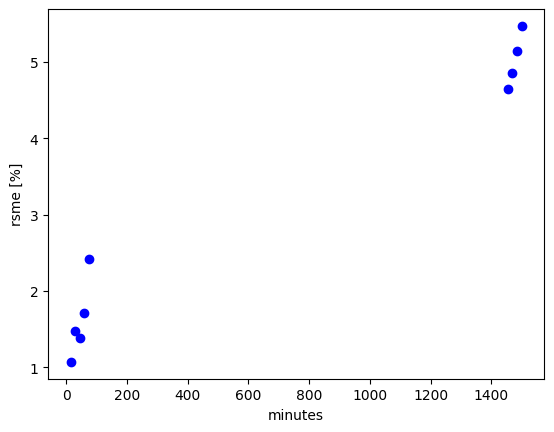

In [97]:
av=np.mean(ser_test.to_predict)
r1=np.loadtxt("xgb2_prelim_0-5_rsmse.txt")
r2=np.loadtxt("xgb2_prelim_96-100_rsmse.txt")
plt.plot(r1[0]*15+15,r1[1]/av*100,'o',color='blue')
plt.plot(r2[0]*15+15,r2[1]/av*100,'o',color='blue')
plt.xlabel("minutes")
plt.ylabel("rsme [%]")

Next make function which can predict flux from the now data point into the future. 

In [ ]:
## Further improvement ideas
- Make feates les hard coded above
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points


In [121]:
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
def predict_from_now2(data,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        res[1,i]=xmodel.predict(data)[-1]
    #need better column names at some points in a data frame     
    return res     

In [22]:
print(comb_real_power.loc[comb_real_power.shape[0]-1,['total_power','frac_day', 'frac_week', 'frac_year']])
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models.sort()
print(models)

KeyError: "['frac_day', 'frac_week', 'frac_year'] not in index"

In [123]:
prediction=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741     12.09550  0.968750   0.852679   0.004706
315742     11.83150  0.979167   0.854167   0.004734
315743     11.72175  0.989583   0.855655   0.004763
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [124]:
prediction2=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741      12.0955  0.968750   0.852679   0.004706
315742      11.8315  0.979167   0.854167   0.004734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

[[11.         16.05557632]
 [11.25       16.3004055 ]
 [11.5        16.71058273]
 [11.75       16.44300652]
 [12.         16.55988121]
 [12.25       16.55244637]
 [12.5        16.56935883]]


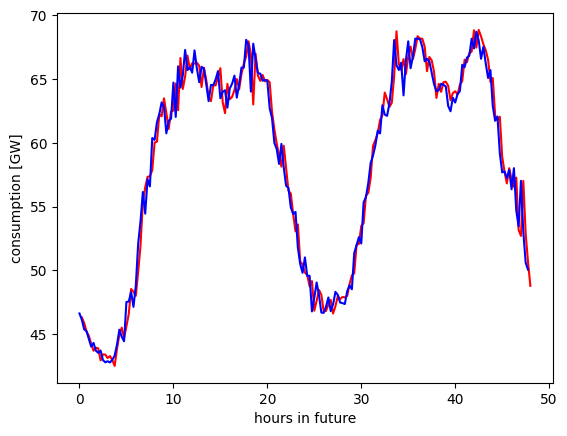

In [125]:
plt.plot(prediction[0],prediction[1]*4,color='red')
plt.plot(prediction2[0]-0.25,prediction2[1]*4,color='blue')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
print(prediction[0:2,43:50].T)

LOoks plausible mostly, also not with much wiggles, but one is rather bad close to 10 hours. 
That seem to be general bad, rerun withg 20% offset regularization start. That solved the problem, others are more like noise without a clear wrong solution. 
Those wiggles are a kind of noise not really expected, whether bad depends on whether it should look better as it is or not. 

Still looks good that it can be implemented. 

## Further improvement ideas
- Need track metrics 
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points
